# Figure S3

### Import packages

In [10]:
import pandas as pd
import larry
import glob
import pathlib
import cellplots as cp

### Get ground truth (`F_obs`)

In [15]:
F_obs = larry.tasks.fate_prediction.F_obs

### Iterate over saved `F_hat` dataframes

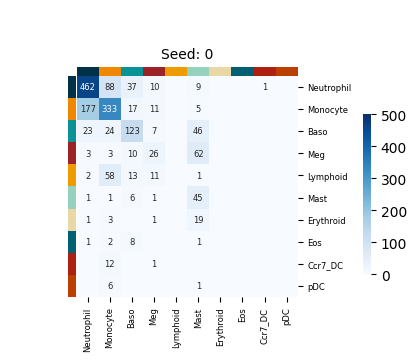

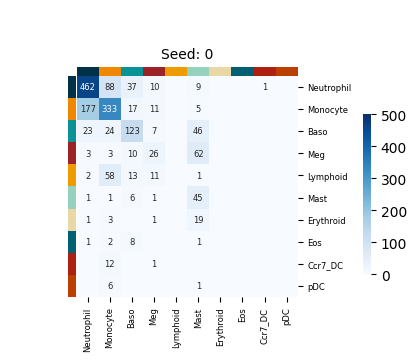

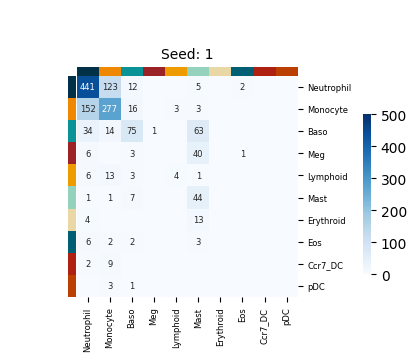

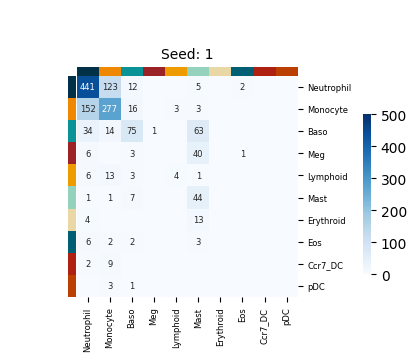

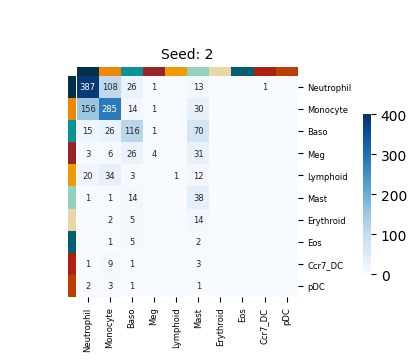

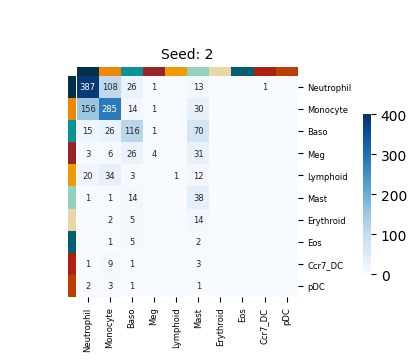

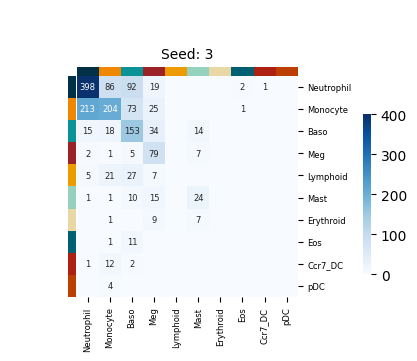

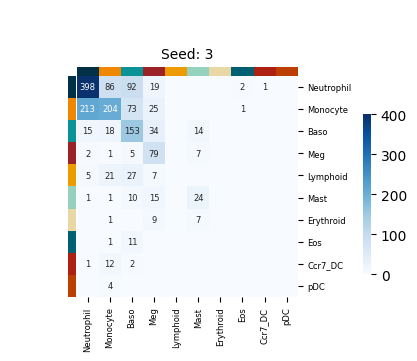

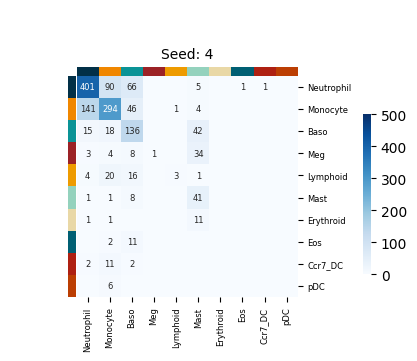

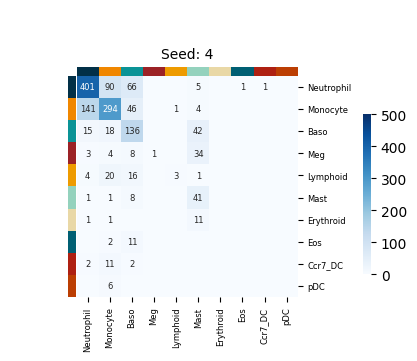

In [35]:
base_path = "/home/mvinyard/experiments/LARRY.full_dataset/v1/LARRY*.csv"
paths = sorted(glob.glob(base_path))
for en, csv_path in enumerate(paths):
    F_hat = pd.read_csv(csv_path, index_col = 0)
    name = pathlib.Path(csv_path).name.split("version_version_")[-1]
    version = int(name.split(".")[0])
    larry.pl.confusion_matrix(F_obs=F_obs, F_hat=F_hat, title=f"Seed: {version}", ax = axes[en], save=f"LARRY.scDiffEqRvR2pt5.confusion_matrix.seed_{version}.svg", dpi=250)
    larry.pl.confusion_matrix(F_obs=F_obs, F_hat=F_hat, title=f"Seed: {version}", ax = axes[en], save=f"LARRY.scDiffEqRvR2pt5.confusion_matrix.seed_{version}.png")
